# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band2.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3       4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039     2040      2041  2042  2043      2044  \
41001 201546 -0.925795  ...  -1.0 -0.88566 -0.892102  -1.0  -1.0 -0.652577   
      201547 -0.925795  ...  -1.0 -0.88566 -0.892102  -1.0  -1.0 -0.652577   
      201548 -0.925795  ...  -1.0 -0.88566 -0.892102  -1.0  -1.0 -0.652577   
      201549 -0.925795  ...  -1.0 -0.88566 -0.892102  -1.0  -1.0 -0.652577   
      201550 -0.925795  ...  -1.0 -0.88566 -0.892102  -1.0  -1.0 -0.652577   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.927806  -1.0 -0.861740  
      201547  -1.0 -0.927806  -1.0 -0.854589  
      201548  -1.0 -0.927806  -1.0 -0.856973  
      201549  -1.0 -0.927806  -1.0 -0.856973  
      201550  -1.0 -0.927806  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3        4    5         6         7  \
5360 201546 -1.0 -1.0 -0.970585 -0.459166 -0.92110 -1.0 -1.000000 -1.000000   
     201547 -1.0 -1.0 -0.687786 -0.978334 -1.00000 -1.0 -0.989216 -1.000000   
     201548 -1.0 -1.0 -0.970585 -0.459166 -0.92110 -1.0 -1.000000 -1.000000   
     201549 -1.0 -1.0 -0.784740 -1.000000 -0.94609 -1.0 -0.963344 -0.969969   
     201550 -1.0 -1.0 -0.970585 -0.459166 -0.92110 -1.0 -1.000000 -1.000000   

                    8         9  ...      2039      2040      2041  2042  \
5360 201546 -1.000000 -0.925795  ... -1.000000 -0.885660 -0.892102  -1.0   
     201547 -0.989441 -1.000000  ... -0.991313 -0.619881 -1.000000  -1.0   
     201548 -1.000000 -0.925795  ... -1.000000 -0.885660 -0.892102  -1.0   
     201549 -0.998486 -0.241021  ... -1.000000 -0.923037 -1.000000  -1.0   
     201550 -1.000000 -0.925795  ... -1.000000 -0.885660 -0.892102  -1.0   

                 2043      2044      2045      2046  2047    Labels  
5360 201546 -1.000000 -0.652577 -1.000000 -0.927806  -1.0 -0.990465  
     201547 -0.926221 -1.000000 -1.000000 -0.899936  -1.0 -0.969011  
     201548 -1.000000 -0.652577 -1.000000 -0.927806  -1.0 -0.995232  
     201549 -0.985316 -0.977133 -0.983972 -0.824868  -1.0 -0.997616  
     201550 -1.000000 -0.652577 -1.000000 -0.927806  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

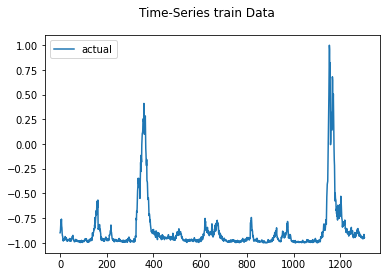

2023-03-06 14:08:02.247970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 14:08:02.248013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 14:08:02.248037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 14:08:02.248275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:08:02.502922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 41.152
Test RMSE: 48.514
Test sMAPE: 128.458
Test R Squared: -1.166
{'mae': 41.151785702427475, 'rmse': 48.513762489234935, 'smape': 128.45842150354784, 'r2': -1.1662886863374933}


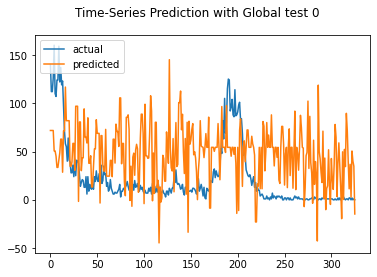

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 42.226
Test RMSE: 53.680
Test sMAPE: 132.429
Test R Squared: -1.652
{'mae': 42.22551472512491, 'rmse': 53.680115593026976, 'smape': 132.4293939904812, 'r2': -1.652242933234568}


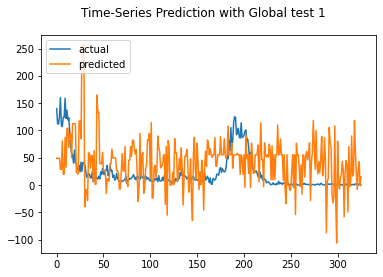

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.252
Test RMSE: 52.064
Test sMAPE: 131.561
Test R Squared: -1.495
{'mae': 45.25164598007144, 'rmse': 52.06436430306818, 'smape': 131.56138972074606, 'r2': -1.4949828022700187}


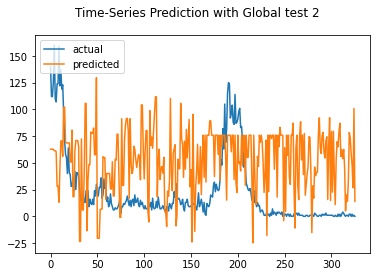

Test MAE: 67.127
Test RMSE: 79.549
Test sMAPE: 143.701
Test R Squared: -4.824
{'mae': 67.12703718162753, 'rmse': 79.54886497709232, 'smape': 143.70051007889145, 'r2': -4.824442886766394}


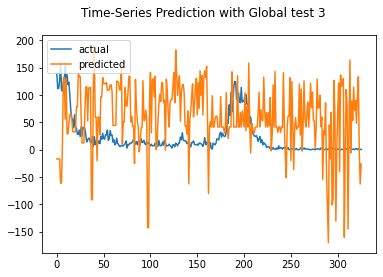

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 48.289
Test RMSE: 61.386
Test sMAPE: 142.491
Test R Squared: -2.468
{'mae': 48.28858669924956, 'rmse': 61.385512983846425, 'smape': 142.4914534558128, 'r2': -2.4683122928157646}


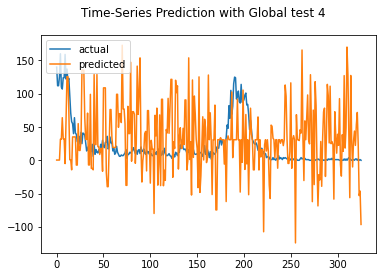

Test MAE: 98.238
Test RMSE: 116.807
Test sMAPE: 155.059
Test R Squared: -11.558
{'mae': 98.23778977862165, 'rmse': 116.80735752773904, 'smape': 155.05883011195286, 'r2': -11.558183210470618}


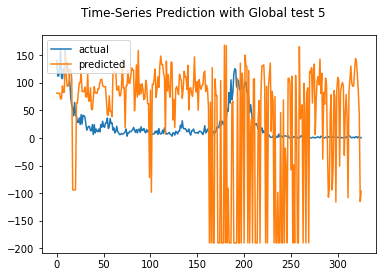

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 63.750
Test RMSE: 77.759
Test sMAPE: 138.292
Test R Squared: -4.565
{'mae': 63.749790449083946, 'rmse': 77.75893863202351, 'smape': 138.29176141695294, 'r2': -4.56528057587819}


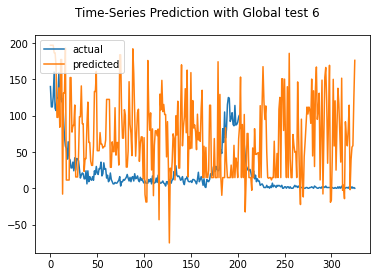

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 52.391
Test RMSE: 58.780
Test sMAPE: 133.746
Test R Squared: -2.180
{'mae': 52.39112951985897, 'rmse': 58.78009760718806, 'smape': 133.74582142845298, 'r2': -2.1801457304447234}


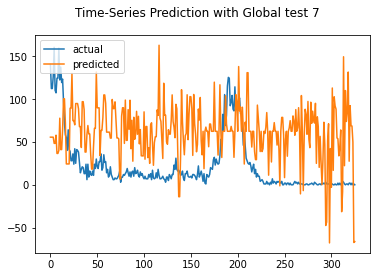

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 54.273
Test RMSE: 66.633
Test sMAPE: 142.784
Test R Squared: -3.087
{'mae': 54.273260949213814, 'rmse': 66.63282835520158, 'smape': 142.78365632765804, 'r2': -3.086607356085165}


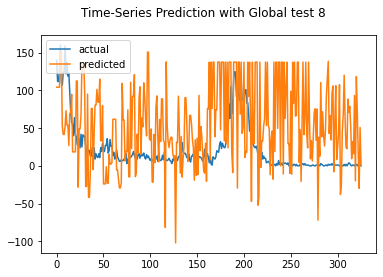

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 66.537
Test RMSE: 76.656
Test sMAPE: 137.194
Test R Squared: -4.408
{'mae': 66.53705736245115, 'rmse': 76.65575034231424, 'smape': 137.19383399285402, 'r2': -4.40848829770828}


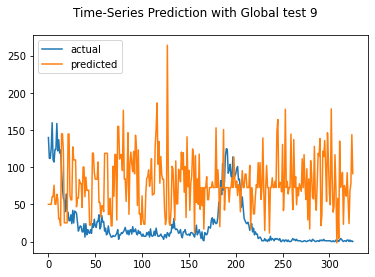

Test MAE: 87.671
Test RMSE: 97.582
Test sMAPE: 155.672
Test R Squared: -7.764
{'mae': 87.67070252763713, 'rmse': 97.58212247194925, 'smape': 155.67152069447425, 'r2': -7.764495781287641}


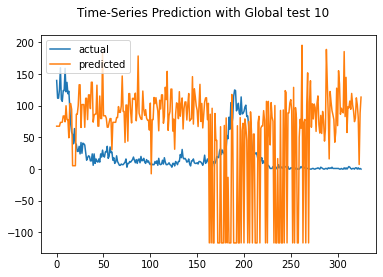

Test MAE: 64.393
Test RMSE: 75.126
Test sMAPE: 137.719
Test R Squared: -4.195
{'mae': 64.3932940872169, 'rmse': 75.12572395091682, 'smape': 137.7190933963741, 'r2': -4.194739291038495}


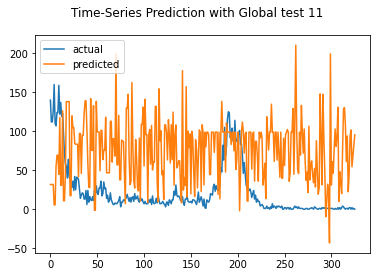

Test MAE: 50.477
Test RMSE: 59.719
Test sMAPE: 141.497
Test R Squared: -2.283
{'mae': 50.47705966563313, 'rmse': 59.719326297408266, 'smape': 141.49740512567547, 'r2': -2.2825867767341794}


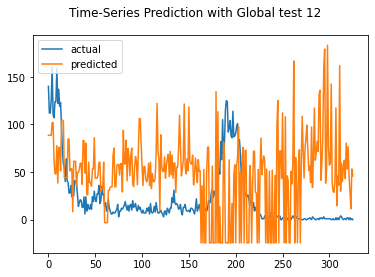

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 62.649
Test RMSE: 72.733
Test sMAPE: 140.744
Test R Squared: -3.869
{'mae': 62.649117739654024, 'rmse': 72.73283889976655, 'smape': 140.74365186687112, 'r2': -3.8690865534278034}


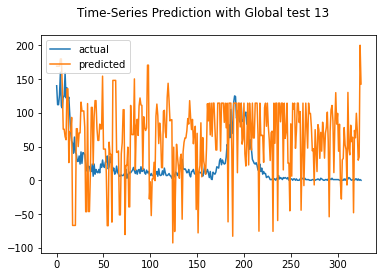

Test MAE: 62.111
Test RMSE: 80.170
Test sMAPE: 127.801
Test R Squared: -4.916
{'mae': 62.11075402366603, 'rmse': 80.16953246500313, 'smape': 127.80053848301603, 'r2': -4.915686054980821}


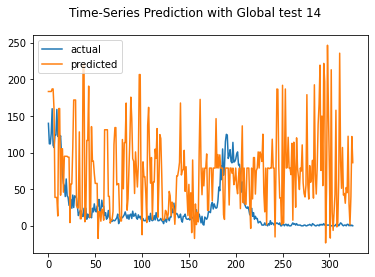

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 57.599
Test RMSE: 70.175
Test sMAPE: 134.900
Test R Squared: -3.533
{'mae': 57.59892747592341, 'rmse': 70.17493705665612, 'smape': 134.90015380125925, 'r2': -3.532632200434594}


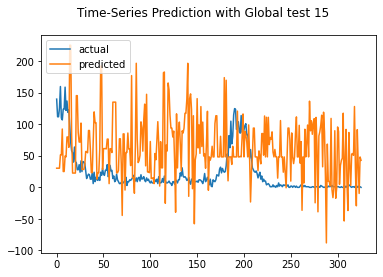

Test MAE: 62.471
Test RMSE: 75.233
Test sMAPE: 146.684
Test R Squared: -4.210
{'mae': 62.470663655023635, 'rmse': 75.2332623998767, 'smape': 146.68376722524235, 'r2': -4.209621917233031}


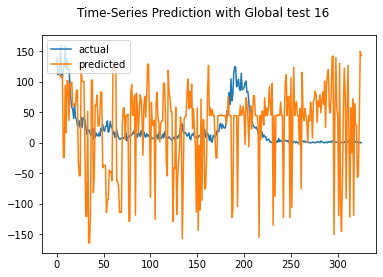

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 50.640
Test RMSE: 57.816
Test sMAPE: 132.765
Test R Squared: -2.077
{'mae': 50.64008558463831, 'rmse': 57.815957765484065, 'smape': 132.764599627657, 'r2': -2.0766767180355594}


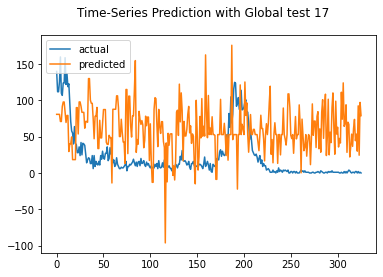

Test MAE: 61.065
Test RMSE: 86.044
Test sMAPE: 157.709
Test R Squared: -5.814
{'mae': 61.06461592018604, 'rmse': 86.04388796475547, 'smape': 157.70857176236564, 'r2': -5.814381888475119}


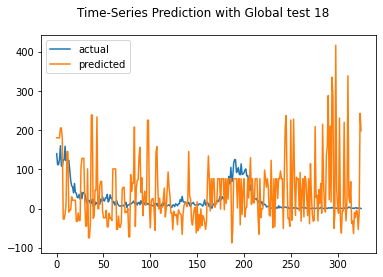

Test MAE: 94.415
Test RMSE: 107.473
Test sMAPE: 156.857
Test R Squared: -9.631
{'mae': 94.41535427819001, 'rmse': 107.47265515992996, 'smape': 156.8572497288567, 'r2': -9.631202073290678}


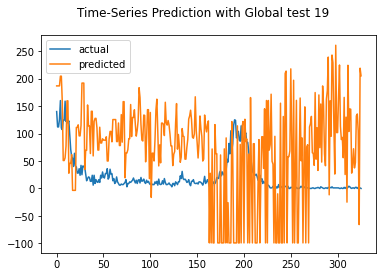

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.323
Test RMSE: 55.479
Test sMAPE: 137.597
Test R Squared: -1.833
{'mae': 47.32315720754898, 'rmse': 55.47875632156491, 'smape': 137.59653732389006, 'r2': -1.832956134140458}


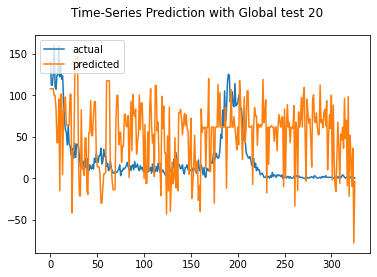

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 49.008
Test RMSE: 60.953
Test sMAPE: 138.256
Test R Squared: -2.420
{'mae': 49.00787362821995, 'rmse': 60.95307008759541, 'smape': 138.2560351662395, 'r2': -2.4196179364545403}


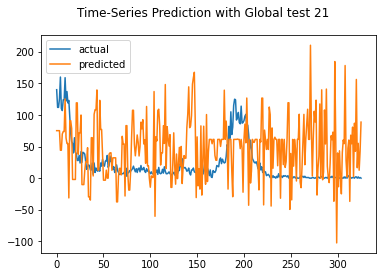

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 53.460
Test RMSE: 61.954
Test sMAPE: 132.696
Test R Squared: -2.533
{'mae': 53.46048996638667, 'rmse': 61.954431173833164, 'smape': 132.69643308824837, 'r2': -2.532898530029521}


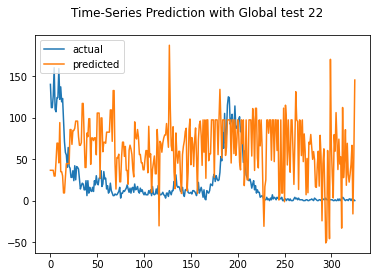

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 44.674
Test RMSE: 57.509
Test sMAPE: 133.471
Test R Squared: -2.044
{'mae': 44.67433830437485, 'rmse': 57.508707314523704, 'smape': 133.47055922890638, 'r2': -2.0440629372895662}


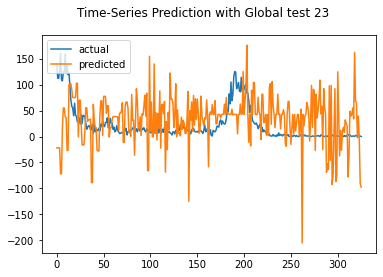

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.845
Test RMSE: 58.493
Test sMAPE: 129.707
Test R Squared: -2.149
{'mae': 49.84498877503389, 'rmse': 58.493166700623, 'smape': 129.70656114158115, 'r2': -2.1491741932763984}


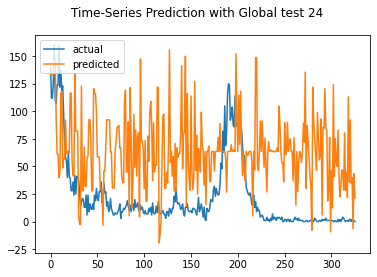

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 58.943
Test RMSE: 67.949
Test sMAPE: 135.631
Test R Squared: -3.250
{'mae': 58.94344921583778, 'rmse': 67.94945357933916, 'smape': 135.6313616233707, 'r2': -3.249700789354434}


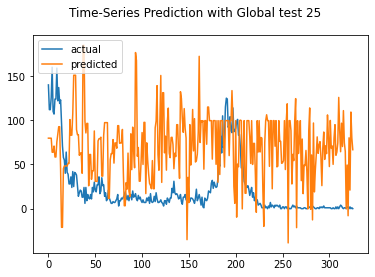

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 41.503
Test RMSE: 50.656
Test sMAPE: 127.217
Test R Squared: -1.362
{'mae': 41.50307044935373, 'rmse': 50.65614416744215, 'smape': 127.21678002719429, 'r2': -1.3618410934753422}


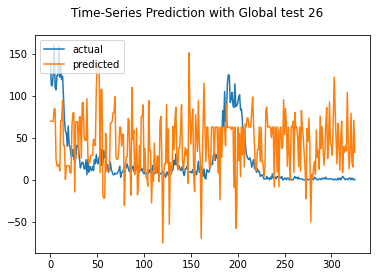

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 52.233
Test RMSE: 62.792
Test sMAPE: 131.361
Test R Squared: -2.629
{'mae': 52.23334264270733, 'rmse': 62.79226254877123, 'smape': 131.3607599364524, 'r2': -2.629097867236697}


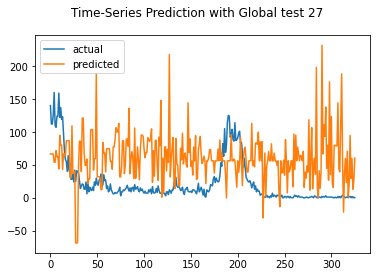

Test MAE: 79.178
Test RMSE: 87.964
Test sMAPE: 157.916
Test R Squared: -6.122
{'mae': 79.17826722370334, 'rmse': 87.9640687998661, 'smape': 157.9162228960125, 'r2': -6.121919087413267}


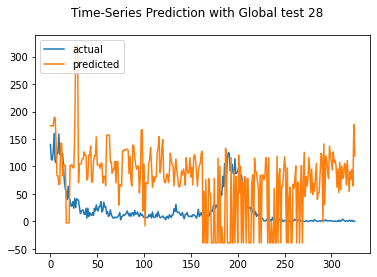

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 42.580
Test RMSE: 55.378
Test sMAPE: 131.593
Test R Squared: -1.823
{'mae': 42.580365410154585, 'rmse': 55.377921530167434, 'smape': 131.5930201552543, 'r2': -1.8226674773575349}


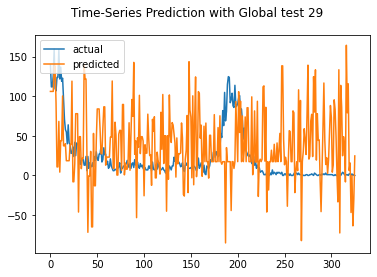

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 47.591
Test RMSE: 58.586
Test sMAPE: 135.463
Test R Squared: -2.159
{'mae': 47.59079804065769, 'rmse': 58.58641837417809, 'smape': 135.46278687104424, 'r2': -2.1592232251919126}


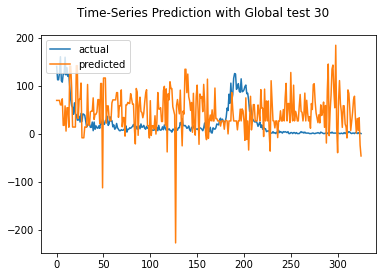

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 42.574
Test RMSE: 50.439
Test sMAPE: 127.891
Test R Squared: -1.342
{'mae': 42.57434947980693, 'rmse': 50.4385211560059, 'smape': 127.89099068205076, 'r2': -1.3415913525710734}


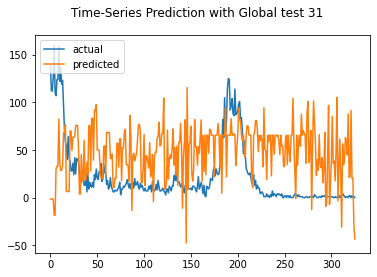

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 42.205
Test RMSE: 53.424
Test sMAPE: 139.627
Test R Squared: -1.627
{'mae': 42.205047025819496, 'rmse': 53.42373857135894, 'smape': 139.62720287102158, 'r2': -1.626969129211905}


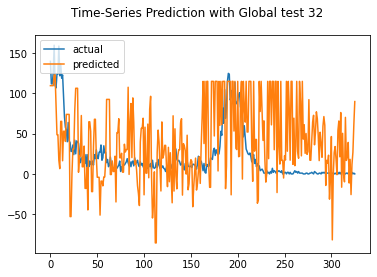

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 57.463
Test RMSE: 73.926
Test sMAPE: 154.386
Test R Squared: -4.030
{'mae': 57.46253410585088, 'rmse': 73.92585079233086, 'smape': 154.38644741725275, 'r2': -4.030128491955972}


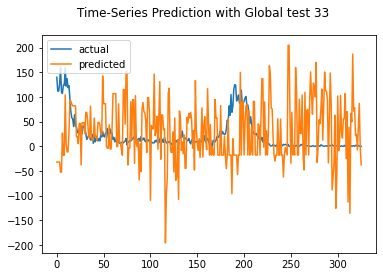

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 47.444
Test RMSE: 57.897
Test sMAPE: 132.894
Test R Squared: -2.085
{'mae': 47.44381391782702, 'rmse': 57.89730239228487, 'smape': 132.89383423746165, 'r2': -2.0853403185215504}


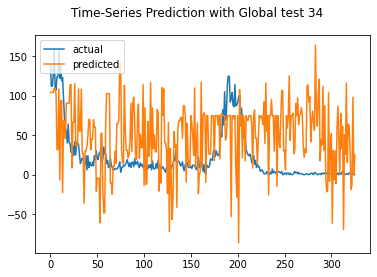

Test MAE: 74.703
Test RMSE: 93.668
Test sMAPE: 149.168
Test R Squared: -7.075
{'mae': 74.70312610871953, 'rmse': 93.66780006946377, 'smape': 149.16771035526043, 'r2': -7.075456029870329}


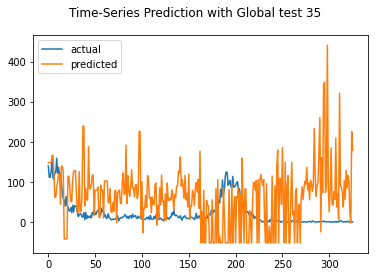

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 53.949
Test RMSE: 66.358
Test sMAPE: 136.758
Test R Squared: -3.053
{'mae': 53.94931494385187, 'rmse': 66.35808095080318, 'smape': 136.75817580138147, 'r2': -3.0529761865817324}


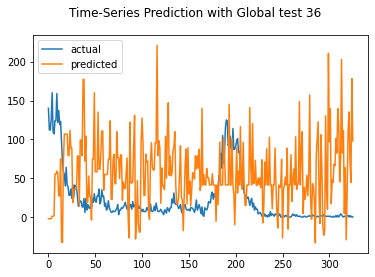

Test MAE: 69.994
Test RMSE: 102.524
Test sMAPE: 145.211
Test R Squared: -8.675
{'mae': 69.99411367327889, 'rmse': 102.52374639720003, 'smape': 145.21064179737277, 'r2': -8.674651984494105}


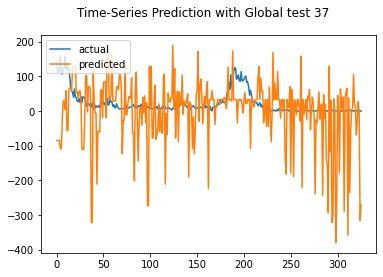

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 63.930
Test RMSE: 72.736
Test sMAPE: 142.108
Test R Squared: -3.870
{'mae': 63.92950864437899, 'rmse': 72.73626636166178, 'smape': 142.10750516856808, 'r2': -3.869545465855693}


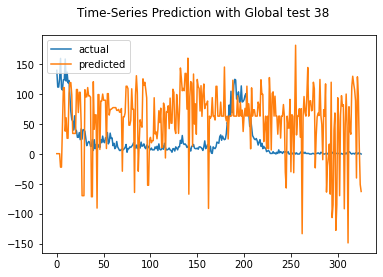

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 42.838
Test RMSE: 54.317
Test sMAPE: 139.090
Test R Squared: -1.716
{'mae': 42.83846795568071, 'rmse': 54.31692328001639, 'smape': 139.08997561215318, 'r2': -1.71554334882169}


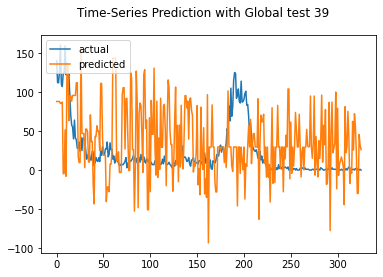

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 58.773
Test RMSE: 74.209
Test sMAPE: 150.490
Test R Squared: -4.069
{'mae': 58.77311325822871, 'rmse': 74.20916831983352, 'smape': 150.49042792761477, 'r2': -4.068757859445897}


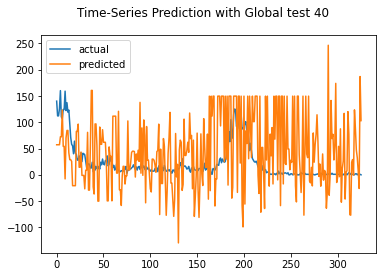

Test MAE: 61.803
Test RMSE: 75.733
Test sMAPE: 137.374
Test R Squared: -4.279
{'mae': 61.80312195584818, 'rmse': 75.73327087504218, 'smape': 137.37379452598205, 'r2': -4.279099462227793}


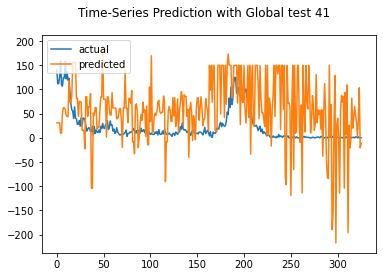

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 50.370
Test RMSE: 57.537
Test sMAPE: 131.279
Test R Squared: -2.047
{'mae': 50.37034021308817, 'rmse': 57.5373527417929, 'smape': 131.27871304797677, 'r2': -2.047096224059034}


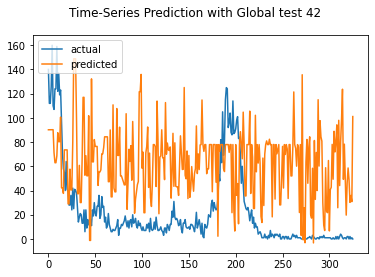

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 55.974
Test RMSE: 69.893
Test sMAPE: 138.985
Test R Squared: -3.496
{'mae': 55.97389595109992, 'rmse': 69.89269837242774, 'smape': 138.98503617323496, 'r2': -3.4962456611301986}


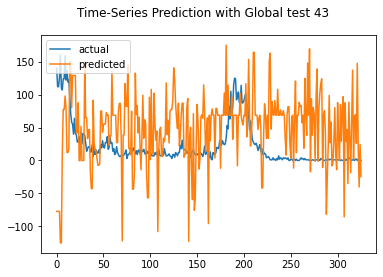

Test MAE: 65.847
Test RMSE: 88.375
Test sMAPE: 136.573
Test R Squared: -6.189
{'mae': 65.8467867932071, 'rmse': 88.37507550147197, 'smape': 136.57267688606692, 'r2': -6.188628028746947}


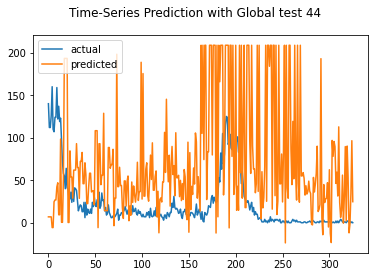

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 55.680
Test RMSE: 62.283
Test sMAPE: 133.780
Test R Squared: -2.570
{'mae': 55.68026236522417, 'rmse': 62.28316206513068, 'smape': 133.78045688946332, 'r2': -2.570489191075198}


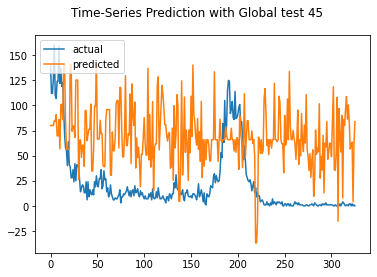

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 52.618
Test RMSE: 67.497
Test sMAPE: 139.887
Test R Squared: -3.193
{'mae': 52.61759168439848, 'rmse': 67.49727013562774, 'smape': 139.887275311885, 'r2': -3.1933279930931553}


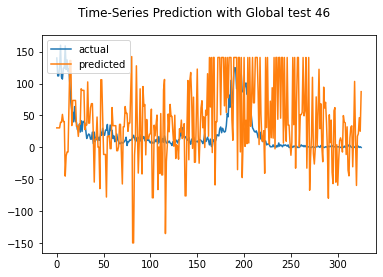

Test MAE: 38.927
Test RMSE: 52.142
Test sMAPE: 129.791
Test R Squared: -1.502
{'mae': 38.926936532913544, 'rmse': 52.14209130421637, 'smape': 129.79071400918386, 'r2': -1.5024378933346347}


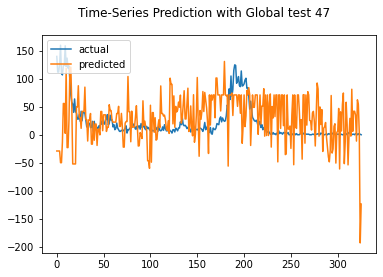

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 48.833
Test RMSE: 56.006
Test sMAPE: 139.180
Test R Squared: -1.887
{'mae': 48.83299703027573, 'rmse': 56.00610740762685, 'smape': 139.1799578562363, 'r2': -1.887069203496012}


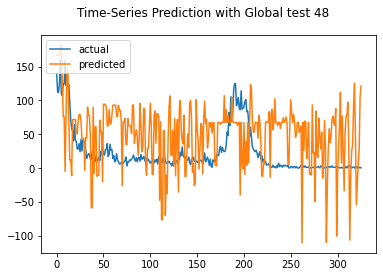

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 59.476
Test RMSE: 68.589
Test sMAPE: 136.786
Test R Squared: -3.330
{'mae': 59.47589407961793, 'rmse': 68.58913828227647, 'smape': 136.7864724793885, 'r2': -3.3300918578839322}


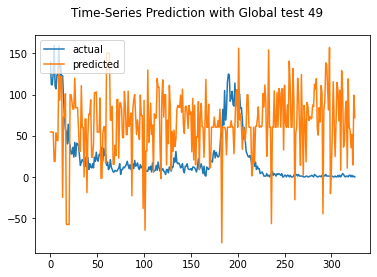

Test MAE: 84.205
Test RMSE: 104.677
Test sMAPE: 152.035
Test R Squared: -9.085
{'mae': 84.20494728439425, 'rmse': 104.67708950503356, 'smape': 152.03497253362895, 'r2': -9.085320259504591}


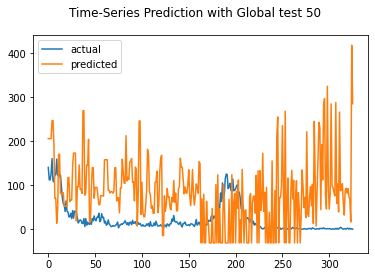

Test MAE: 84.264
Test RMSE: 107.288
Test sMAPE: 146.014
Test R Squared: -9.595
{'mae': 84.2644743604894, 'rmse': 107.28779234721665, 'smape': 146.01409652453103, 'r2': -9.59466024495533}


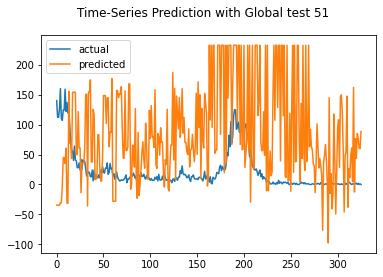

Test MAE: 73.989
Test RMSE: 82.529
Test sMAPE: 142.236
Test R Squared: -5.269
{'mae': 73.98915402289549, 'rmse': 82.52866959547757, 'smape': 142.23590183176785, 'r2': -5.268968742816313}


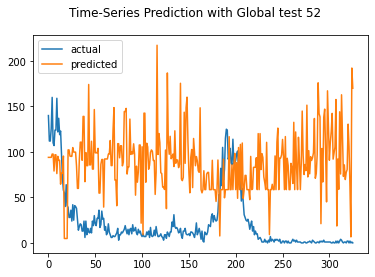

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 47.536
Test RMSE: 59.470
Test sMAPE: 141.370
Test R Squared: -2.255
{'mae': 47.53589448908721, 'rmse': 59.470472765140656, 'smape': 141.37017737858318, 'r2': -2.255286357679855}


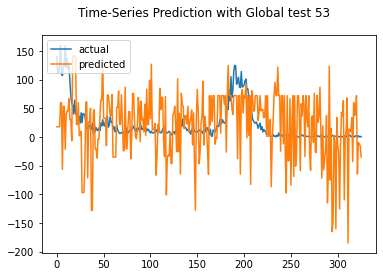

Test MAE: 62.470
Test RMSE: 87.345
Test sMAPE: 147.702
Test R Squared: -6.022
{'mae': 62.4704164471363, 'rmse': 87.34543034137319, 'smape': 147.70157744940718, 'r2': -6.022096509757437}


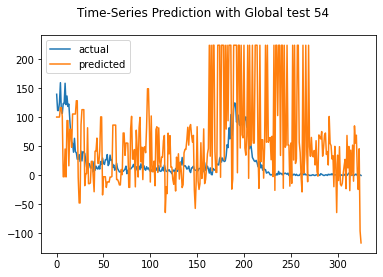

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.729
Test RMSE: 57.222
Test sMAPE: 129.860
Test R Squared: -2.014
{'mae': 49.72940707517548, 'rmse': 57.222480737650145, 'smape': 129.85991731968517, 'r2': -2.0138371331636953}


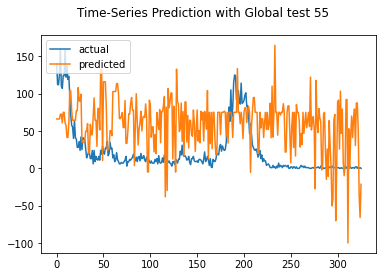

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 44.662
Test RMSE: 54.432
Test sMAPE: 126.430
Test R Squared: -1.727
{'mae': 44.66174425961781, 'rmse': 54.43163492401517, 'smape': 126.42997128732088, 'r2': -1.7270253457911275}


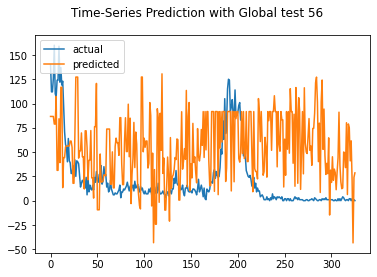

Test MAE: 45.491
Test RMSE: 54.256
Test sMAPE: 124.093
Test R Squared: -1.709
{'mae': 45.491488232203054, 'rmse': 54.256072718268285, 'smape': 124.09255782642292, 'r2': -1.709462379252571}


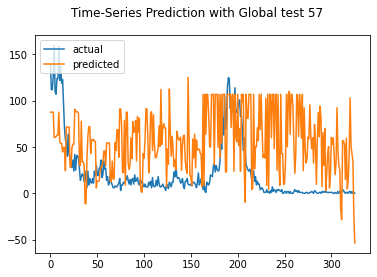

Test MAE: 55.539
Test RMSE: 63.003
Test sMAPE: 136.178
Test R Squared: -2.653
{'mae': 55.53930003584528, 'rmse': 63.00294681100257, 'smape': 136.17780987870057, 'r2': -2.6534918444723585}


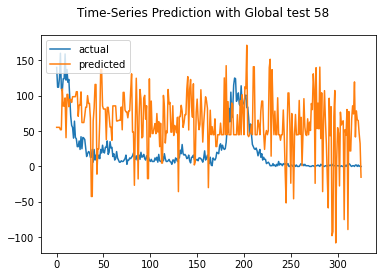

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 54.805
Test RMSE: 68.010
Test sMAPE: 137.621
Test R Squared: -3.257
{'mae': 54.804725940333554, 'rmse': 68.01036052761351, 'smape': 137.62085617029732, 'r2': -3.257322699387471}


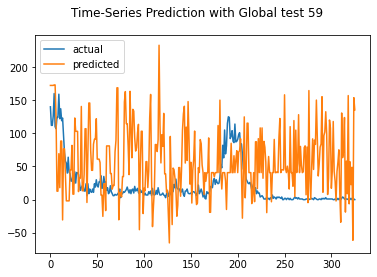

Test MAE: 67.373
Test RMSE: 77.776
Test sMAPE: 149.586
Test R Squared: -4.568
{'mae': 67.37326099170498, 'rmse': 77.77594727544628, 'smape': 149.58614311452848, 'r2': -4.5677154914531375}


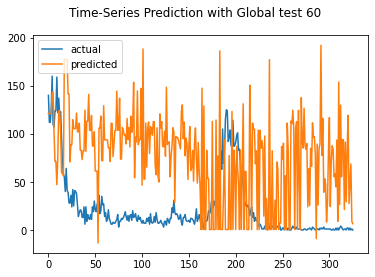

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 55.839
Test RMSE: 66.995
Test sMAPE: 140.814
Test R Squared: -3.131
{'mae': 55.8387925743691, 'rmse': 66.99536565321007, 'smape': 140.81350996933563, 'r2': -3.1311973290235375}


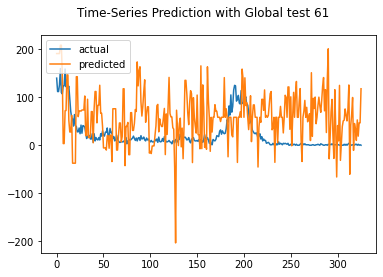

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.824
Test RMSE: 59.198
Test sMAPE: 137.013
Test R Squared: -2.225
{'mae': 48.82352734233704, 'rmse': 59.1976847132218, 'smape': 137.01284875941673, 'r2': -2.2254911813575924}


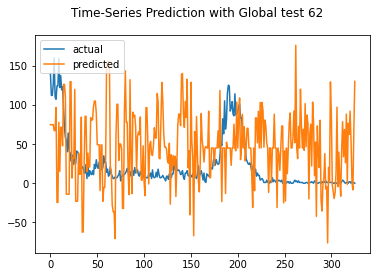

Test MAE: 58.557
Test RMSE: 71.291
Test sMAPE: 141.367
Test R Squared: -3.678
{'mae': 58.55706988137924, 'rmse': 71.29146917000148, 'smape': 141.36671117282992, 'r2': -3.6780143064592394}


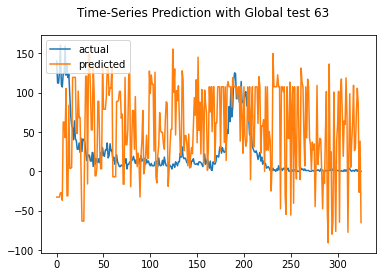

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.230
Test RMSE: 56.243
Test sMAPE: 128.149
Test R Squared: -1.912
{'mae': 46.22966629870099, 'rmse': 56.24310552312038, 'smape': 128.1491094381085, 'r2': -1.9115550212874943}


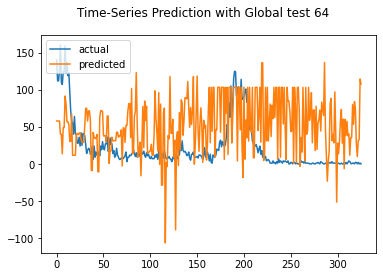

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 56.957
Test RMSE: 69.015
Test sMAPE: 153.329
Test R Squared: -3.384
{'mae': 56.95739975132825, 'rmse': 69.01513746266232, 'smape': 153.32851821475157, 'r2': -3.3840462878558393}


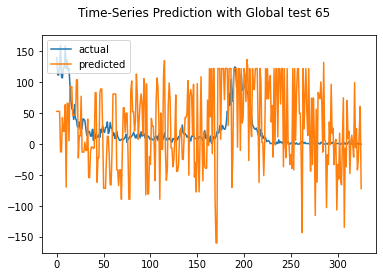

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.840
Test RMSE: 60.743
Test sMAPE: 138.192
Test R Squared: -2.396
{'mae': 50.83950216601963, 'rmse': 60.743228997639164, 'smape': 138.1924066972375, 'r2': -2.3961132576593447}


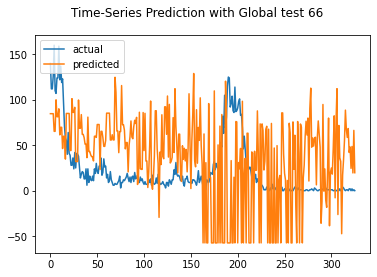

Test MAE: 60.808
Test RMSE: 77.556
Test sMAPE: 132.289
Test R Squared: -4.536
{'mae': 60.8077345110156, 'rmse': 77.55599853255391, 'smape': 132.2894463486859, 'r2': -4.536269254475125}


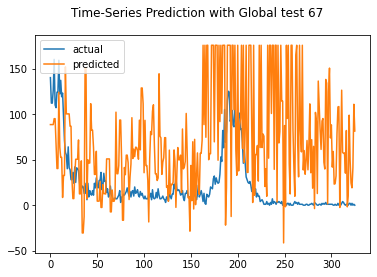

Test MAE: 85.989
Test RMSE: 96.729
Test sMAPE: 147.137
Test R Squared: -7.612
{'mae': 85.9891600711214, 'rmse': 96.72936236868081, 'smape': 147.13715802706133, 'r2': -7.611981061836435}


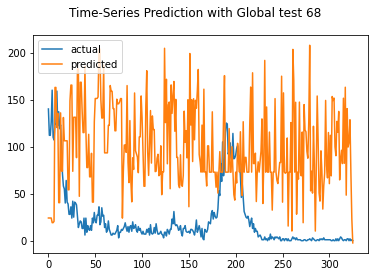

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 55.687
Test RMSE: 68.546
Test sMAPE: 150.583
Test R Squared: -3.325
{'mae': 55.686741972079304, 'rmse': 68.545999195602, 'smape': 150.58333694462257, 'r2': -3.324646754767744}


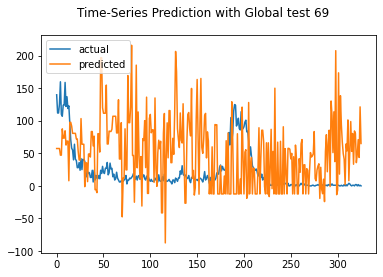

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 44.966
Test RMSE: 59.111
Test sMAPE: 146.406
Test R Squared: -2.216
{'mae': 44.966470943272476, 'rmse': 59.110599768223736, 'smape': 146.40580206729643, 'r2': -2.216008205278436}


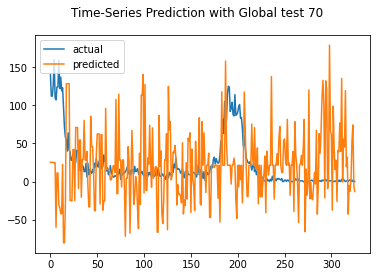

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 57.026
Test RMSE: 64.458
Test sMAPE: 133.229
Test R Squared: -2.824
{'mae': 57.025693878074364, 'rmse': 64.45780784164128, 'smape': 133.22855310083946, 'r2': -2.8241725435024776}


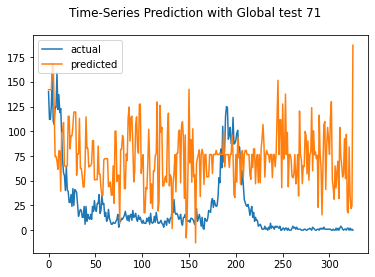

Test MAE: 46.944
Test RMSE: 57.025
Test sMAPE: 126.366
Test R Squared: -1.993
{'mae': 46.9435740071206, 'rmse': 57.02473991811369, 'smape': 126.3655480833181, 'r2': -1.993043595203753}


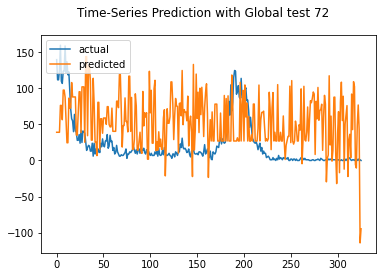

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.155
Test RMSE: 53.914
Test sMAPE: 134.472
Test R Squared: -1.675
{'mae': 47.15521991618572, 'rmse': 53.913828352351295, 'smape': 134.47163517777528, 'r2': -1.675387905588988}


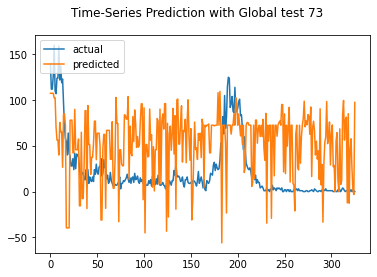

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 39.340
Test RMSE: 51.263
Test sMAPE: 127.421
Test R Squared: -1.419
{'mae': 39.34029277903171, 'rmse': 51.26337982350208, 'smape': 127.42142689901306, 'r2': -1.4188051708519351}


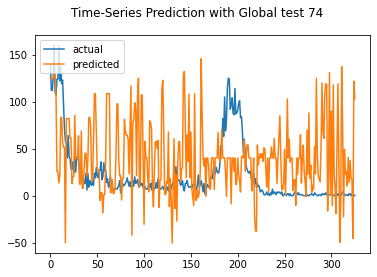

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 48.749
Test RMSE: 57.992
Test sMAPE: 147.436
Test R Squared: -2.095
{'mae': 48.74868204174963, 'rmse': 57.99227061866237, 'smape': 147.4357081897016, 'r2': -2.095470310609642}


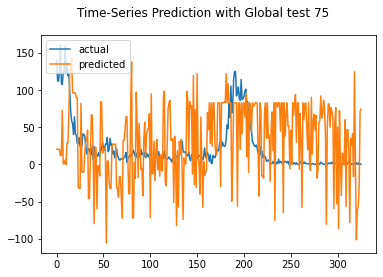

Test MAE: 50.002
Test RMSE: 65.671
Test sMAPE: 140.839
Test R Squared: -2.969
{'mae': 50.00167701251668, 'rmse': 65.67110578649522, 'smape': 140.83911985831108, 'r2': -2.969493310808028}


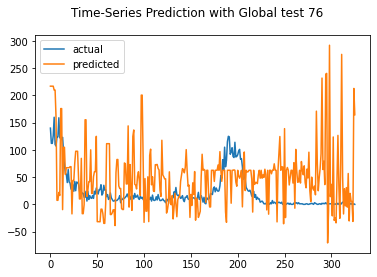

Test MAE: 49.508
Test RMSE: 64.039
Test sMAPE: 142.599
Test R Squared: -2.775
{'mae': 49.50833167985905, 'rmse': 64.0393661340139, 'smape': 142.59918939584912, 'r2': -2.7746828278725917}


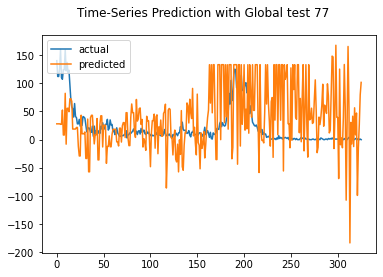

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.475
Test RMSE: 56.380
Test sMAPE: 133.877
Test R Squared: -1.926
{'mae': 47.47518057124746, 'rmse': 56.38011947812685, 'smape': 133.87693695289923, 'r2': -1.9257579915677039}


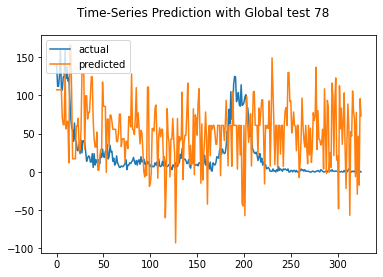

Test MAE: 58.375
Test RMSE: 71.523
Test sMAPE: 142.328
Test R Squared: -3.708
{'mae': 58.375173965663265, 'rmse': 71.52250264125607, 'smape': 142.32795383755368, 'r2': -3.708383413137417}


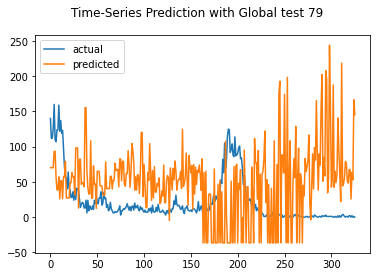

Test MAE: 78.880
Test RMSE: 90.036
Test sMAPE: 147.102
Test R Squared: -6.461
{'mae': 78.87989525359832, 'rmse': 90.03575927134017, 'smape': 147.10187241203246, 'r2': -6.46133395933425}


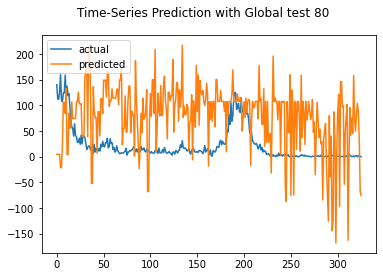

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 62.399
Test RMSE: 73.782
Test sMAPE: 140.936
Test R Squared: -4.011
{'mae': 62.39882257489339, 'rmse': 73.7822612696551, 'smape': 140.93563144250643, 'r2': -4.010606977115277}


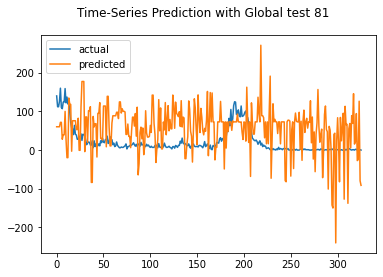

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 62.364
Test RMSE: 75.258
Test sMAPE: 136.205
Test R Squared: -4.213
{'mae': 62.36399581461596, 'rmse': 75.25751893245469, 'smape': 136.20451110786377, 'r2': -4.212981807027991}


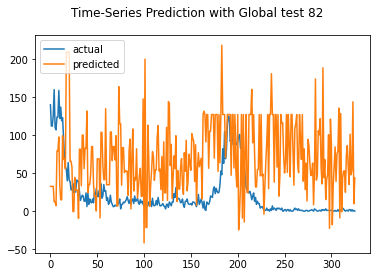

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 48.302
Test RMSE: 55.782
Test sMAPE: 130.041
Test R Squared: -1.864
{'mae': 48.302156107923004, 'rmse': 55.78240188514391, 'smape': 130.04118778858256, 'r2': -1.8640515903609072}


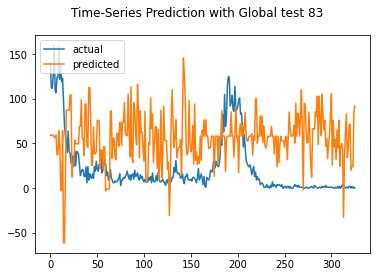

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 42.983
Test RMSE: 51.779
Test sMAPE: 131.829
Test R Squared: -1.468
{'mae': 42.98296104408115, 'rmse': 51.77931836478047, 'smape': 131.8291007815682, 'r2': -1.467738144649792}


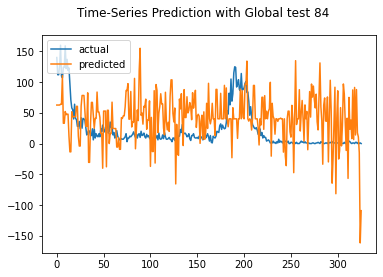

Test MAE: 108.469
Test RMSE: 126.866
Test sMAPE: 152.517
Test R Squared: -13.814
{'mae': 108.46945094897703, 'rmse': 126.86587077616916, 'smape': 152.51745086732743, 'r2': -13.814125708009545}


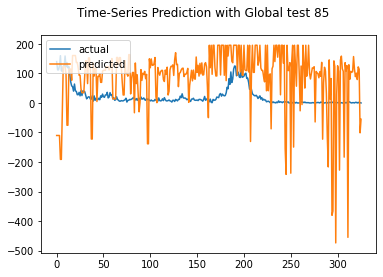

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 50.978
Test RMSE: 58.115
Test sMAPE: 130.906
Test R Squared: -2.109
{'mae': 50.97820593279564, 'rmse': 58.114970127102055, 'smape': 130.90611528896102, 'r2': -2.1085829024610874}


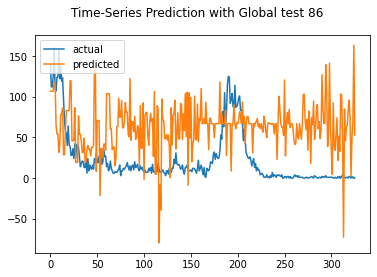

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.254
Test RMSE: 59.032
Test sMAPE: 131.239
Test R Squared: -2.208
{'mae': 50.254172578545436, 'rmse': 59.03238207820916, 'smape': 131.2392295822425, 'r2': -2.207502715440239}


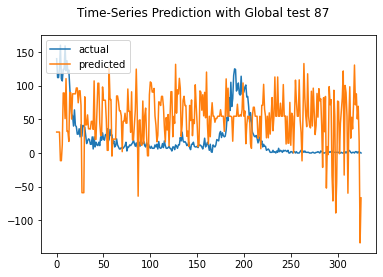

Test MAE: 68.801
Test RMSE: 74.795
Test sMAPE: 141.258
Test R Squared: -4.149
{'mae': 68.80084408134039, 'rmse': 74.79456294374208, 'smape': 141.2578948363427, 'r2': -4.149042467183012}


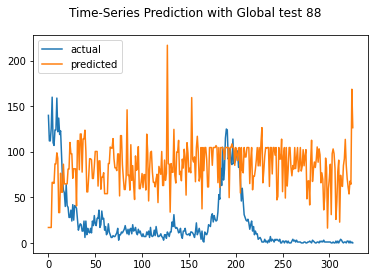

Test MAE: 61.421
Test RMSE: 67.293
Test sMAPE: 138.846
Test R Squared: -3.168
{'mae': 61.421217037856216, 'rmse': 67.29284559510526, 'smape': 138.84630943865915, 'r2': -3.167966343802303}


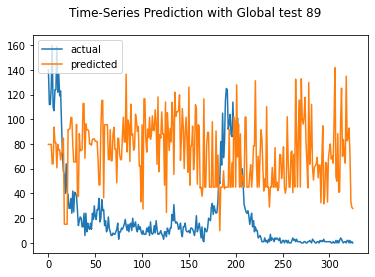

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.909
Test RMSE: 49.814
Test sMAPE: 125.703
Test R Squared: -1.284
{'mae': 41.90934221108267, 'rmse': 49.814014610589304, 'smape': 125.70292813416765, 'r2': -1.2839653124657566}


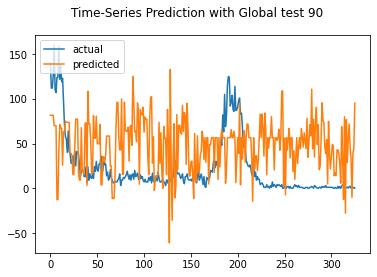

Test MAE: 72.135
Test RMSE: 91.842
Test sMAPE: 144.686
Test R Squared: -6.764
{'mae': 72.13486270889913, 'rmse': 91.84191346133571, 'smape': 144.6860644409915, 'r2': -6.763691377048503}


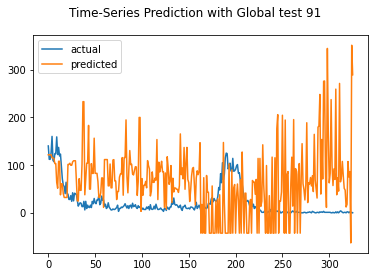

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 53.245
Test RMSE: 65.790
Test sMAPE: 141.005
Test R Squared: -2.984
{'mae': 53.24471525345112, 'rmse': 65.78969483136972, 'smape': 141.00535086731364, 'r2': -2.9838424966492636}


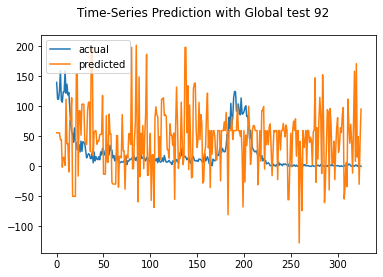

Test MAE: 72.174
Test RMSE: 112.582
Test sMAPE: 132.317
Test R Squared: -10.666
{'mae': 72.17445806665289, 'rmse': 112.58169252512562, 'smape': 132.31679526323634, 'r2': -10.665999758669427}


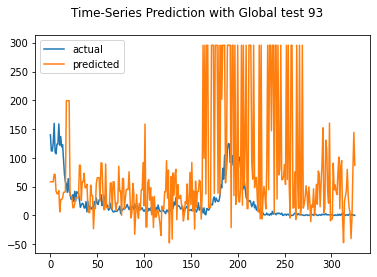

Test MAE: 68.008
Test RMSE: 89.304
Test sMAPE: 137.685
Test R Squared: -6.340
{'mae': 68.00805247744168, 'rmse': 89.30354510217735, 'smape': 137.68497956862518, 'r2': -6.340469106997231}


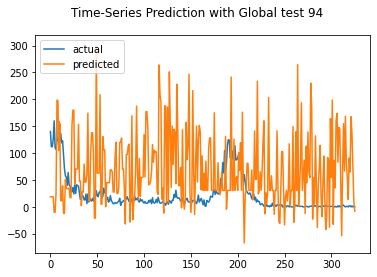

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 57.461
Test RMSE: 70.419
Test sMAPE: 165.501
Test R Squared: -3.564
{'mae': 57.46061217912867, 'rmse': 70.41860579395392, 'smape': 165.50054459386538, 'r2': -3.5641642066825288}


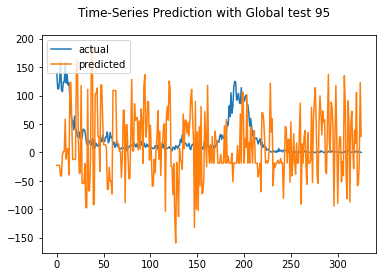

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 56.751
Test RMSE: 65.923
Test sMAPE: 132.557
Test R Squared: -3.000
{'mae': 56.75144097044424, 'rmse': 65.92296593704428, 'smape': 132.5569199703574, 'r2': -2.9999990954296263}


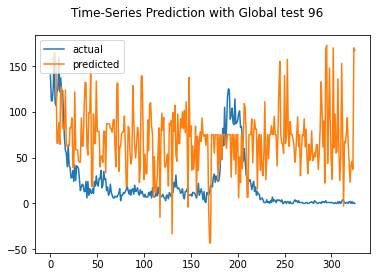

Test MAE: 43.289
Test RMSE: 51.928
Test sMAPE: 126.660
Test R Squared: -1.482
{'mae': 43.28904291457194, 'rmse': 51.92831148479472, 'smape': 126.6600645359055, 'r2': -1.481960231938555}


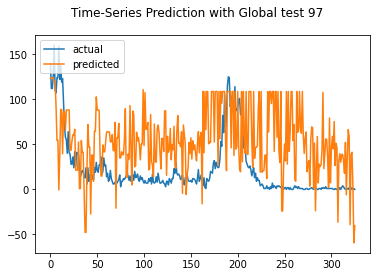

Test MAE: 117.925
Test RMSE: 134.628
Test sMAPE: 161.085
Test R Squared: -15.682
{'mae': 117.92526764738048, 'rmse': 134.6277621210008, 'smape': 161.0845435643469, 'r2': -15.682290116734876}


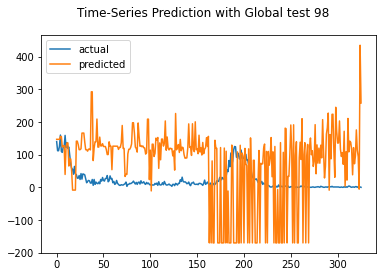

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 49.573
Test RMSE: 58.931
Test sMAPE: 129.410
Test R Squared: -2.197
{'mae': 49.57343838916966, 'rmse': 58.931168932456096, 'smape': 129.4104571294702, 'r2': -2.196513386407591}


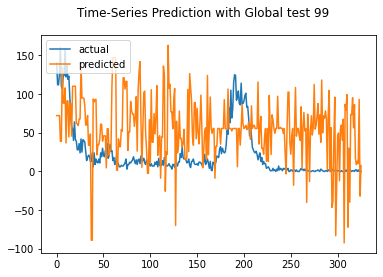

rmse : average=70.168, std=17.525
mae : average=57.891, std=14.572
smape : average=139.047, std=8.760
r2 : average=-3.814, std=2.696


([70.16765338387825, 17.524878755037413],
 [57.89123188583397, 14.571723260737127],
 [139.04683542310738, 8.760192293324147],
 [-3.8143722342233066, 2.6958799642447357])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
